## Задание 4
### Нахождение параметров системы с помощью метода MCMC

Требуется найти параметры системы Хищник-Жертва при помощи метода MCMC.  
Результатом является записная книжка Python Notebook в которой: 
1. Задаются параметры системы Хищник-Жертва 
2. Решается прямая задача и генерируются данные 
3. К данными применяется зашумление 
4. Методом MCMC оцениваются параметры системы по зашумленным данным 


\begin{align}
\dot{x} & = (\alpha-\beta y)x \\
\dot{y} & = (-\gamma+\delta x)y, \
\ \alpha = 1, \
\ \beta = 0.4, \ 
\ \gamma = 1.5, \
\ \delta = 0.4 \\ 
\end{align}

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

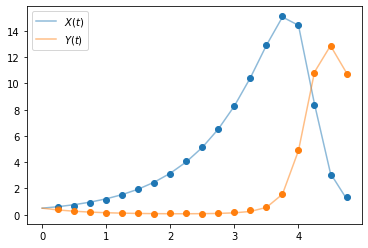

In [35]:
def PredatorPrey(y, t, p):
    #x, y = vec
    dx = (p[0] - p[1]*y[1])*y[0]
    dy = (-p[2] + p[3]*y[0])*y[1]
    return [dx, dy]


times = np.arange(0, 5, 0.25)

alpha, beta, gamma, delta = 1.0, 0.4, 1.5, 0.4

# Create true curves

y = odeint(PredatorPrey,  y0=[0.5, 0.5], t=times,args=((alpha, beta, gamma, delta),), rtol=1e-8)

yobs = np.clip(np.random.normal(loc = y[1::], scale = 0.05), a_min = 0, a_max = None)

plt.plot(times[1::], yobs, marker="o", linestyle="none")
plt.plot(times, y[:, 0], color="C0", alpha=0.5, label=f"$X(t)$")
plt.plot(times, y[:, 1], color="C1", alpha=0.5, label=f"$Y(t)$")
plt.legend()
plt.show()



In [36]:
PredatorPrey_model = DifferentialEquation(
    func=PredatorPrey,
    times=np.arange(0.25, 5, 0.25), # не включаем начальную точку
    n_states=2, # Размерность системы ОДУ 
    n_theta=4, # Размерность вектора параметров
    t0=0,
)

In [40]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)

    alpha = pm.Uniform("alpha", 0.1, 2.0)
    beta = pm.Uniform("beta", 0.1, 2.0)
    gamma = pm.Uniform("gamma", 0.1, 2.0)
    delta = pm.Uniform("delta", 0.1, 2.0)
    
    PredatorPrey_curves = PredatorPrey_model(y0=[0.5, 0.5], theta=[alpha, beta, gamma, delta])

    Y = pm.Normal("Y", mu=PredatorPrey_curves, sigma=sigma, observed=yobs)

    trace = pm.sample(80, tune=40, target_accept=0.9, cores=1)
    data = az.from_pymc3(trace=trace)

<ipython-input-40-12a081929317>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(80, tune=40, target_accept=0.9, cores=1)
Only 80 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
D:\SOFT\Anaconda\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [delta, gamma, beta, alpha, sigma]


Sampling 2 chains for 40 tune and 80 draw iterations (80 + 160 draws total) took 2539 seconds.
D:\SOFT\Anaconda\lib\site-packages\pymc3\sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5361205223413075, but should be close to 0.9. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5455514016642645, but should be close to 0.9. Try to increase the number of tuning steps.


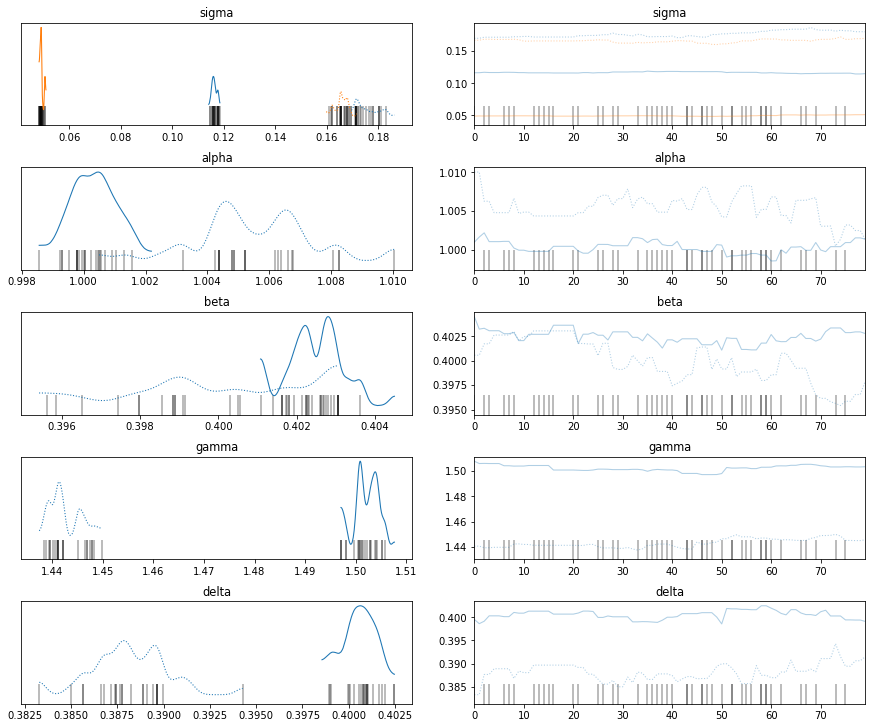

In [41]:
with model4:
    az.plot_trace(trace)

array([[<AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

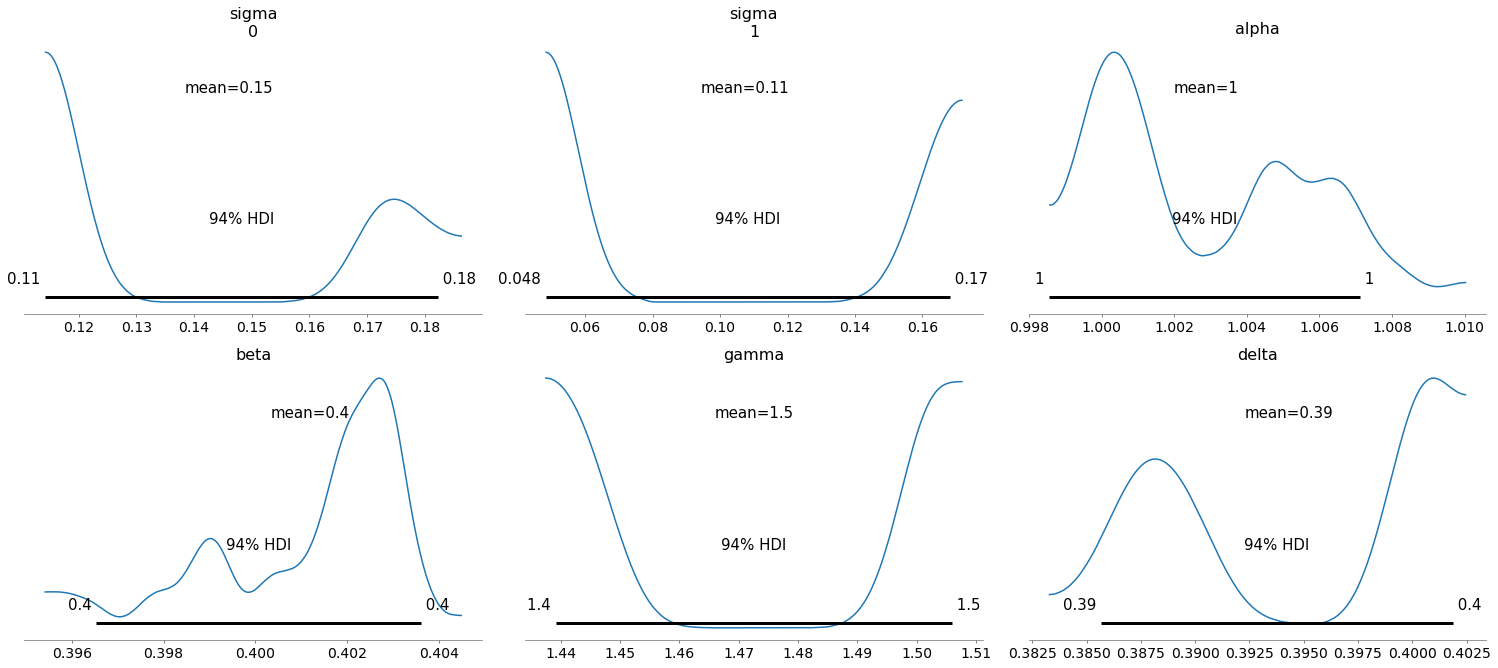

In [42]:
az.plot_posterior(data, round_to=2)